# Create a Video from a Script and Images

This notebook pulls data from an Excel file containing a list of influential figures. It is able to convert text into speech and then combine this with images to produce a video ready for YouTube. The section at the end also allows the user to create a thumbnail for the video and produces a description from a template.

The scripts have been generated using ChatGPT with the prompt "Generate 10 pretty long and interesting facts about \<Influential Figure>". If a script is generated but no audio available then the code will create an audio file based on the script and a pre-made intro and outro. The user must add picutres to a folder of the figure and if they are available but no video produced then the code will calculate a duration for all images and create a video from these images and the audio clip.

Once that is done the video will be saved to the Videos folder but a copy will be in the main repository for ease when uploading to YouTube. You then can make a thumbnail out of images in the respective figures Images file or a seperate image before adding text to the image to make it stand out. A description is also returned for easy uploading.

## Load modules

In [35]:
import os

In [36]:
os.environ["IMAGEIO_FFMPEG_EXE"] = "/Users/user/Documents/GitHub/Video-from-Script/ffmpeg"
from moviepy.editor import *

In [37]:
import pandas as pd
import numpy as np
import shutil
import docx2txt # Import word files
import openpyxl # Save files to Excel
import random # For thumbnail
import datetime
from PIL import Image, ImageFont, ImageDraw, ImageFilter # Resizing thumbnail and adding text
import json
import openai
from openai._client import OpenAI
from docx import Document
import time
import wikipedia
import re
import edge_tts
from edge_tts import VoicesManager
from colorthief import ColorThief
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Load/Prepare Data Files

### Set Locations

Here we set all of the locations for the data as well as loading in the pre-made Intro, Description, and Outro.

In [62]:
script_loc = "/Volumes/BCross/Documents/YouTube/Scripts/"
images_loc = "/Volumes/BCross/Documents/YouTube/Formatted Images/"
thumbnails_loc = "/Volumes/BCross/Documents/YouTube/Thumbnails/"
set_scripts_loc = "/Volumes/BCross/Documents/YouTube/Set Scripts/"
audio_loc = "/Volumes/BCross/Documents/YouTube/Audio/"
video_loc = "/Volumes/BCross/Documents/YouTube/Video/"

# Get the Intro
intro = docx2txt.process(set_scripts_loc + 'Intro.docx')

# Get the Description
description = docx2txt.process(set_scripts_loc + 'Description.docx')

# Get the Outro
outro = docx2txt.process(set_scripts_loc + 'Outro.docx')

### Load the dataframe of information

Here we load in the dataframe containing the information on the influential figures before adding the prompt and making sure we have no duplicates in the names. We the overwrite the file.

In [39]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')

In [40]:
# Remove duplicate names
historical_figures_list = historical_figures_list.drop_duplicates(subset = ['Name'])


# Posted Videos
posted_list = historical_figures_list[(historical_figures_list.Youtube_Video_Posted == "Yes")]

# Videos Made
video_made_list = historical_figures_list[(historical_figures_list.Youtube_Video_Created == "Yes") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
video_made_list = video_made_list.sample(frac = 1)

# Images Added
images_made_list = historical_figures_list[(historical_figures_list.Images_Obtained == "Yes") &
                                           (historical_figures_list.Youtube_Video_Created == "No") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
images_made_list = images_made_list.sample(frac = 1)

# Voice Generated
audio_made_list = historical_figures_list[(historical_figures_list.AI_Voice_Generated == "Yes") &
                                           (historical_figures_list.Images_Obtained == "No") &
                                           (historical_figures_list.Youtube_Video_Created == "No") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
audio_made_list = audio_made_list.sample(frac = 1)

# Script Generated
script_made_list = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                           (historical_figures_list.AI_Voice_Generated == "No") &
                                           (historical_figures_list.Images_Obtained == "No") &
                                           (historical_figures_list.Youtube_Video_Created == "No") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
script_made_list = script_made_list.sample(frac = 1)

# No Script Generated
no_script_made_list = historical_figures_list[(historical_figures_list.Script_Created == "No")]
no_script_made_list = no_script_made_list.sample(frac = 1)

# Update the figure list
historical_figures_list = pd.concat([posted_list, video_made_list, images_made_list,
                                     audio_made_list,script_made_list,no_script_made_list])

historical_figures_list['Figure_ID'] = range(len(historical_figures_list))
historical_figures_list['Figure_ID'] = historical_figures_list['Figure_ID'] + 1

historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

## Need Script

In [41]:
# Here we want to capture any figures who need audio. We can create this in one loop.
need_script = historical_figures_list[(historical_figures_list.Script_Created == "No")]

In [42]:
need_script

,Figure_ID,Name,Description,Script_Created,AI_Voice_Generated,Images_Obtained,Youtube_Video_Created,Youtube_Video_Posted,Youtube_URL,Word_Count,Model_Used,Wikipedia


In [43]:
def parse_wikipedia_url(url):
    # Parse a wikipedia url to get the title
    match = re.search(r'/([^/]+)$', url)
    return match.group(1)

def get_context(url):
    # Get the title from the wiki URL
    page_title = parse_wikipedia_url(url)
    
    page = wikipedia.page(title=page_title,
                          auto_suggest=False,
                          redirect=True)

    context = page.content
    
    return context

In [44]:
# We only do this if audio is needed
if need_script.shape[0] > 0:
    
    # Initialise OpenAI and create the function to get the results 
    os.environ["OPENAI_API_KEY"] = json.load(open("Credentials.json"))['OPENAI_API_KEY']
    client = OpenAI()
    
    # llm_model="gpt-4"
    # llm_model="gpt-3.5-turbo-1106"
    llm_model = "gpt-4-1106-preview"

    def get_completion(prompt, model=llm_model):
        messages = [{"role": "user", "content": prompt}]
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0.5, 
        )
        return response.choices[0].message.content
    
    
    # Get the figures we need scripts for
    figure_scripts = list(need_script.iloc[:,1].values)
    
    for figure in figure_scripts:

        wiki_url = historical_figures_list.loc[(historical_figures_list.Name == figure),'Wikipedia'].values[0]

        context = get_context(wiki_url)
        
        prompt_output = """I would like this in a JSON format where each key is a fact number and each value is a fact e.g.
        [
            {"1": "fact 1"},
            {"2": "fact 2"},
            ....,
            {"10": "fact 10"}
        ]"""

#         prompt = f"Please provide me with 10 very long and interesting facts about {figure}. " \
#         f"I have a youtube channel based on influential figures so this information must be accurate as my channel depends on it. " \
#         f"Please make each fact approximately 300 tokens long. " \
#         f"{prompt_output}"
        
        prompt = f"Please provide me with 10 very long and interesting facts about {figure} using only the context given below." \
        f"I have a youtube channel based on influential figures so this information must be accurate as my channel depends on it. " \
        f"Please make each fact approximately 300 tokens long. " \
        f"Context: ```{context}```" \
        f"{prompt_output}"
    
        response = get_completion(prompt)
        
        # Find the index of the first '[' and the last ']'
        start_index = response.find('[')  # Find first square brackets
        end_index = response.rfind(']') +1  # +1 to keep the bracket, rfind finds the last occurrence

        # Slice the string
        if start_index > 0 and end_index > 0 and end_index > start_index:
            result = response[start_index:end_index]
        else:
            result = ''
    
        resp_dict = json.loads(result)

        # Extracting values from each dictionary and joining them with a space
        script = ' '.join(d[str(i+1)] for i, d in enumerate(resp_dict))

        # Count the number of words in the paragraph
        word_count = len(script.split())

        # Print the figure's name and the word count
        print(f"{figure}: {word_count} Words")
        
        # Create a new Document
        doc = Document()

        # Add the paragraph to the document
        doc.add_paragraph(script)

        save_loc = "Scripts/" + figure + ".docx"
        # Save the document
        
        doc.save(save_loc)
        
        # Convert the No to Yes in needs audio column
        historical_figures_list.iloc[(historical_figures_list.Name == figure),3] = "Yes"
        historical_figures_list.iloc[(historical_figures_list.Name == figure),9] = word_count
        historical_figures_list.iloc[(historical_figures_list.Name == figure),10] = llm_model
        
        # Once all done stop the engine and then overwrite the Excel file
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
        
        time.sleep(30)
    
    print("Complete, my guy!")

## Create Any Necessary Audio Files

This code checks if there are any figures who have a script saved but no audio. If there isn't any audio then the code creates some and saves it to the Audio folder with the figures name as the file name. It then updates the Excel file to show that the audio has been saved.

In [45]:
# Here we want to capture any figures who need audio. We can create this in one loop.
need_audio = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "No")]

In [46]:
need_audio

,Figure_ID,Name,Description,Script_Created,AI_Voice_Generated,Images_Obtained,Youtube_Video_Created,Youtube_Video_Posted,Youtube_URL,Word_Count,Model_Used,Wikipedia


In [47]:
def generate_audio(text_loc, voice, figure, intro = "./Set Scripts/Intro.docx",
                   outro = "./Set Scripts/Outro.docx", save_loc = "./Audio/"):

    # Get the script
    data = docx2txt.process(text_loc)
    # Remove any of the elements below
    data = data.replace('\r', ' ').replace('\n\n', ' ').replace('\n', ' ')
    # Get the intro and outro
    intro = docx2txt.process(intro)
    
    intro = intro.replace("[Historical Figure]", figure)
    
    outro = docx2txt.process(outro)
    # Combine the three
    data = intro + "  " + data + "  " + outro
    
    # Replace any quotation marks
    data = data.replace('"', "'")
    
    # Complete the command
    command1 = f'edge-tts --voice "{voice}" --text "{data}" --write-media "{save_loc}"'
    os.system(command1)

In [48]:
# We only do this if audio is needed
if need_audio.shape[0] > 0:
    # Randomly choose an English US voice
    voices = await VoicesManager.create()
    # Get the list of english US voices
    voice = voices.find(Language="en", Locale="en-US")
    # Filter out annoying voice
    voice = list(filter(lambda v: v['ShortName'] != 'en-US-AnaNeural', voice))
    
    # Create figure filepaths
    figure_scripts = list(need_audio.iloc[:,1].values + '.docx')
    
    # Now want to loop through the figures, getting the script, the figures name and then
    # saving the audio before changing the value in the Excel file for needs audio to yes.
    for figure in figure_scripts:
        
        # Choose random voice out of those remaining
        voice_chosen = random.choice(voice)["ShortName"]
        
        # Get the figure name
        fig = os.path.splitext(figure)[0]
        
        # Location of the scripts
        text_loc = script_loc + figure
        
        # Location to save the audio
        save_loc = audio_loc + fig + ".mp3"
        
        # Run the generate_audio function
        generate_audio(text_loc, voice_chosen, fig, save_loc = save_loc)
        
        # Convert the No to Yes in needs audio column
        historical_figures_list.iloc[(historical_figures_list.Name == fig),4] = "Yes"
    
        # Once all done stop the engine and then overwrite the Excel file
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
    
    print("Complete, my guy!")

## Check For Images

Next we want to check to see if there are any figures who have images in the Images folder but i have forgot to change the images value to yes

In [49]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')
# We grab any that still need images
need_images = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                      (historical_figures_list.AI_Voice_Generated == "Yes") &
                                      (historical_figures_list.Images_Obtained == "No")]

In [50]:
# If there are figures with images needed we will check to see if there are actually images there and then if there
# are we will change the images obtained value to yes.
if need_images.shape[0] > 0:
    
    # List all of the figures needing images
    figures_image = list(need_images.iloc[:,1].values)
    
    for figure in figures_image:
        # Create the filepath
        image_path = images_loc + figure
        
        # If there are any figures where the folder path exists
        if os.path.exists(image_path) == True:
            # Check the number of files and if more than zero. Make changes to document
            if len(os.listdir(image_path + '/')) > 0:
                historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
                historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
          
need_images = need_images[(need_images.Images_Obtained == "No")]

In [51]:
need_images

,Figure_ID,Name,Description,Script_Created,AI_Voice_Generated,Images_Obtained,Youtube_Video_Created,Youtube_Video_Posted,Youtube_URL,Word_Count,Model_Used,Wikipedia
193,194,Lleyton Hewitt,Tennis player,Yes,Yes,No,No,No,NaN,1071.0,gpt-4-1106-preview,https://en.wikipedia.org/wiki/Lleyton_Hewitt
194,195,Julia Roberts,Julia Roberts captured hearts with her radiant...,Yes,Yes,No,No,No,NaN,627.0,gpt-4-1106-preview,https://en.wikipedia.org/wiki/Julia_Roberts
195,196,Mustafa Kemal Atatürk,"Founder and first President of Turkey, known f...",Yes,Yes,No,No,No,NaN,621.0,gpt-4-1106-preview,unavailable
196,197,Rosika Schwimmer,"A Hungarian-born feminist, revolutionary, and ...",Yes,Yes,No,No,No,NaN,741.0,gpt-4-1106-preview,https://en.wikipedia.org/wiki/Rosika_Schwimmer
197,198,Bayard Rustin,An American civil rights activist and organize...,Yes,Yes,No,No,No,NaN,737.0,gpt-4-1106-preview,unavailable
...,...,...,...,...,...,...,...,...,...,...,...,...
275,276,Vincent van Gogh,One of the most influential painters of the Po...,Yes,Yes,No,No,No,NaN,818.0,gpt-4-1106-preview,unavailable
276,277,Maria Mutola,"Mozambican middle-distance runner, Olympic gol...",Yes,Yes,No,No,No,NaN,969.0,gpt-4-1106-preview,unavailable
277,278,Tom Hanks,"With an impressive range, Tom Hanks has starre...",Yes,Yes,No,No,No,NaN,957.0,gpt-4-1106-preview,https://en.wikipedia.org/wiki/Tom_Hanks
278,279,Tina Fey,One of the most successful comedians of all ti...,Yes,Yes,No,No,No,NaN,784.0,gpt-4-1106-preview,unavailable


## Convert Images from Folder

My first method is a manual add a figures images if you already have them saved in a folder you can convert them with the following function.

In [51]:
def convert_images_from_folder(figure):
    
    image_path = images_loc + figure
    quality_val = 90
    images = os.listdir(image_path)
    
    
    images = [ i for i in images if i != '.DS_Store']
    
    images_kept = 1
    thumbnail_options = 1
    
    for image in images:
        
        image_location = image_path + "/" + image
        save_location = image_path + "/test.png"
        
        # Load as image object
        selected_image = Image.open(image_location)
        selected_image.save(save_location)

        # This plots the image so we can see it
        %matplotlib inline
        img = mpimg.imread(save_location)
        imgplot = plt.imshow(img)
        plt.show()
        
        # Text to whether i want to save the image as a thumbnail option
        thumbnail = input("Use as thumbnail? Y or N: ")
                
        if thumbnail == "Y" or thumbnail == "y":
            selected_image.save(image_path + "/thumbnail" + str(thumbnail_options) + ".png", 
                                quality=quality_val)
            thumbnail_options += 1
                
        # We want all images to be the same size. If they aren't resize them.
        h = selected_image.height
        w = selected_image.width
                
        if h > 480:
            h = 480
            selected_image = selected_image.resize((w, h), Image.LANCZOS)
        if w > 720:
            w = 720
            selected_image = selected_image.resize((w, h), Image.LANCZOS)

        start_pos_w = 360 - w/2
        start_pos_h = 240 - h/2
 
        # Want to paste the resized image onto dominant colour background
        color_thief = ColorThief(save_location)
        # get the dominant color
        dominant_color = color_thief.get_color(quality=1)
        # Background
        bk = Image.new('RGB', (720, 480), color = dominant_color)
        # paste background image on to border image
        bk.paste(selected_image, (int(start_pos_w), int(start_pos_h)))
                
        bk.save(image_path + "/" + str(images_kept) + '.png',
                quality=quality_val)
                
        
        # Change the image obtained to yes for the specified figure and save
        historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
        
        # Remove the test image
        os.remove(save_location)
        
        os.remove(image_location)
        
        images_kept += 1
        
    print("All Done Laa!")

In [52]:
# convert_images_from_folder('Katie Ledecky')

### Random Figure Selection and Image Conversion

In [53]:
figure_sample = list(need_images['Name'].sample(5))

print(figure_sample)

['Franklin D. Roosevelt', 'Yayoi Kusama', 'Aung San Suu Kyi', 'Noureddine Morceli', 'Al-Kindi']


In [54]:
for figure in figure_sample:
    try: convert_images_from_folder(figure)
    except: continue

## Add Video

Next we wish to check if any figures have a script, an audio and images available but there is no video recorded. If this is the case then the code will loop through the figures and combine the audio and images together to create a vide and save it in the Video folder before finally adjusting the table to show this.

In [55]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')
# We will grab any figures who have a script and audio complete but no video.
need_video = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "Yes") &
                                     (historical_figures_list.Images_Obtained == "Yes") &
                                     (historical_figures_list.Youtube_Video_Created == "No")]

In [56]:
need_video

,Figure_ID,Name,Description,Script_Created,AI_Voice_Generated,Images_Obtained,Youtube_Video_Created,Youtube_Video_Posted,Youtube_URL,Word_Count,Model_Used,Wikipedia
192,193,Ivan Lendl,Tennis player,Yes,Yes,Yes,No,No,NaN,1370.0,gpt-4o,https://en.wikipedia.org/wiki/Ivan_Lendl


In [57]:
if need_video.shape[0] > 0:

    # Get the figures who need a video making
    figure_video = list(need_video.iloc[:,1].values)
    
    for figure in figure_video:
        # Get the locations
        audio_location = audio_loc + figure + '.mp3'
        image_location = images_loc + figure + '/'
        video_location = video_loc + figure + '.mp4'
        
        # Add audio clip and get the duration
        audio_clip = AudioFileClip(audio_location)
        audio_duration = audio_clip.duration
        
        # Get the time each image will show for, remove thumbnail options
        possible_images = os.listdir(image_location)
        possible_images = [image for image in possible_images if "thumbnail" not in image]
        possible_images = [ i for i in possible_images if i != '.DS_Store']
        
        number_of_images = len(possible_images)
        image_duration = audio_duration / number_of_images

        # Here we create the frames for each image and their duration
        img_names = possible_images
        img = list(image_location + img for img in img_names)

        clips = [ImageClip(m).set_duration(image_duration)
                 for m in img]

        # Combine the images together into a single clip
        concat_clip = concatenate_videoclips(clips, method = "compose")

        # add the audio
        concat_clip.audio = audio_clip

        # Write the video with audio included
        concat_clip.write_videofile(video_location, fps = 24)

        # Add Yes to the video created column
        historical_figures_list.iloc[(historical_figures_list.Name == figure),6] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

Moviepy - Building video /Volumes/BCross/Documents/YouTube/Video/Ivan Lendl.mp4.
MoviePy - Writing audio in Ivan LendlTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /Volumes/BCross/Documents/YouTube/Video/Ivan Lendl.mp4



Moviepy - Done !
Moviepy - video ready /Volumes/BCross/Documents/YouTube/Video/Ivan Lendl.mp4


## Functions for Youtube Upload

Here are the functions used in the upload process

In [58]:
def create_description(string, string_to_replace, figure, model):
    
    llm_model = historical_figures_list.loc[historical_figures_list['Name'] == figure, 'Model_Used'].iloc[0]
    wiki_link = historical_figures_list.loc[historical_figures_list['Name'] == figure, 'Wikipedia'].iloc[0]

    # Create YouTube description
    modified_string = string.replace(string_to_replace, figure)
    modified_string = modified_string.replace(model, llm_model)
    
    if wiki_link == "unavailable":
        modified_string = modified_string.replace("[Source – wiki_url]", "")
        modified_string = re.sub(r'\n{4,}', '\n\n', modified_string)
    else:
        modified_string = modified_string.replace("[Source – wiki_url]", f"Source - {wiki_link}")
    return(modified_string)

In [59]:
def move_video(figure):
    # We want to move the video to the main file directory
    import shutil
    video_location = video_loc + figure + '.mp4'
    shutil.copy2(video_location, "video.mp4")

In [59]:
def thumbnail_generator(image_location, title_text, YT_logo_location, YT_channel,
                       font_location, save_location):

    # Add image as an object
    my_image = Image.open(image_location)

    # 1280 × 720 pixels - thumbnail size
    max_image_size = (1280, 720)

    # Set the image size to the max
    my_image.thumbnail(max_image_size)

    ### PROFILE PICTURE IN CORNER ###
    # Add the youtube profile picture
    profile_pic = Image.open(YT_logo_location).convert("RGBA")
    # Add random background, doesn't matter what
    background = Image.new("RGBA", profile_pic.size, (0,0,0,0))

    mask = Image.new("RGBA", profile_pic.size, 0)
    draw = ImageDraw.Draw(mask)
    
    # Crop the circle
    draw.ellipse((0,0,int(profile_pic.size[0]),int(profile_pic.size[0])),
                 fill='green', outline=None)

    # Make the image
    profile_pic = Image.composite(profile_pic, background, mask)

    # resize profile pic
    profile_pic = profile_pic.resize((200, 200))

    ### GET DOMINANT COLOUR FOR BACKGROUND AND TEXT COLOUR ###
    
    # Get the dominant colour of the image
    from colorthief import ColorThief
    color_thief = ColorThief(image_location)
    # get the dominant color
    dominant_color = color_thief.get_color(quality=1)

    # To get whether text will be white or black
    if (0.299 * dominant_color[0]) + (0.587 * dominant_color[1]) + (0.114 * dominant_color[2]) > 186:
        contrast_colour = tuple([0, 0, 0])
    else: 
            contrast_colour= tuple([255, 255, 255])

    ### PASTE IMAGES TOGETHER ###
    
    # Sizing down image 
    my_image = my_image.resize((int(500), 680))

    # Create background and add the border and background image
    # Border
    img = Image.new('RGB', (1280, 720), color = contrast_colour)
    # Background
    img2 = Image.new('RGB', (1260, 700), color = dominant_color)
    # paste background image on to border image
    img.paste(img2, (10, 10))
    # Add my image on top
    img.paste(my_image, (20, 20))
    # Add the profile pic
    img.paste(profile_pic, (1060, 500), mask = profile_pic)

    ### FONTSIZE GENERATOR ###
    
    # Get the text for the title
    title_text = title_text
    
    fontsize = 1  # starting font size
    # Get the font and initialise the size
    font = ImageFont.truetype(font_location, fontsize)
    # Remaining size of image
    breakpoint = 720
    # Large jumps to speed up process
    jumpsize = 75

    # Loops through fontsizes and finds the max which fits all of the text
    while True:
        if font.getsize(title_text)[0] < breakpoint:
            fontsize += jumpsize
        else:
            jumpsize = jumpsize // 2
            fontsize -= jumpsize
        font = ImageFont.truetype(font_location, fontsize)
        if jumpsize <= 1:
            break

    # This returned huge font for small number of characters so workaround in place
    # This was done with trial and error
    if fontsize > 190:
        fontsize = 190
        font = ImageFont.truetype(font_location, fontsize)
        subtitle_size = int(fontsize / 2)
        start_pos = -20
        subtitle_start = 160
    elif fontsize <= 100:
        subtitle_size = 90
        start_pos = 20
        subtitle_start = 50 + int(fontsize / 2)
    else:
        subtitle_size = int(fontsize / 2)
        start_pos = - 10
        subtitle_start = 80 + int(fontsize / 2)

    # Allow for drawing on the image
    image_editable = ImageDraw.Draw(img)

    # Add the title
    image_editable.text((540, start_pos), title_text, contrast_colour, font = font)

    # Add the subtitle
    title_font = ImageFont.truetype(font_location, subtitle_size )
    title_text = "10 Interesting Facts"
    image_editable.text((540, subtitle_start), title_text, contrast_colour, font = title_font)

    # Add the youtube handle
    title_font = ImageFont.truetype(font_location, 40)
    title_text = YT_channel
    image_editable.text((540, 655), title_text, contrast_colour, font = title_font)

    img.save(save_location)
    # img.show()

    # This plots the image so we can see it
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(save_location)
    imgplot = plt.imshow(img)
    plt.show()
    


## Youtube Preparation - Don't Need This Unless Manual Upload

In [74]:
def YouTube_preparation(historical_figure):
    move_video(historical_figure)
    print("#--------------------TITLE--------------------#\n")
    print(historical_figure, "- 10 Interesting Facts\n")
    print("#-----------------DESCRIPTION-----------------#\n")
    video_description = create_description(description, "[Historical Figure]", historical_figure, "[model]")
    print(video_description)
    print("\n")
    
    # Images for tumbnail function
    image_location = images_loc + historical_figure + "/"
    t_loc = thumbnails_loc + historical_figure +  "/"
    all_images = os.listdir(image_location)
    thumbnails = os.listdir(t_loc)
    thumbnails = [x for x in thumbnails if x.startswith('t')]
    thumbnails.sort()
    
    option = 1
    for thumbnail in thumbnails:
        
        print_option = "#-----------------THUMBNAIL " + str(option) + "-----------------#\n"
        print(print_option)
        
        save_location = t_loc + thumbnail
        thumbnail_generator(image_location = f"{t_loc}{thumbnail}",
                            title_text = historical_figure,
                            YT_logo_location = 'YT Profile.jpg',
                            YT_channel = "@Figures_In_History",
                            font_location = "./Fonts/BebasKai.ttf",
                            save_location = save_location)
        option += 1
    
    i = 0
    while i == 0:
        string = "Choose which thumbnail you would like to use: 1 to " + str(len(thumbnails))
        thumbnail_choice = input(string)
          
        if int(thumbnail_choice) > len(thumbnails):
            i = 0
        else:
            file_loc = t_loc + "thumbnail" + thumbnail_choice + ".png"
            #file_loc = "./Thumbnails/" + historical_figure + "-" + "thumbnail" + thumbnail_choice + ".png"
            shutil.copy(file_loc, "thumbnail.png")
            i = 1

#--------------------TITLE--------------------#

Ivan Lendl - 10 Interesting Facts

#-----------------DESCRIPTION-----------------#

Welcome to Figures in History! In this episode, we delve into the life and legacy of Ivan Lendl. Join us as we uncover ten key facts about this influential individual who left an indelible mark on history. From their groundbreaking achievements to their remarkable journey, we explore the captivating story behind Ivan Lendl

Subscribe to Figures in History for more captivating stories of influential figures who shaped our world. Don't forget to hit the notification bell to stay updated with our latest episodes. We value your input, so leave a comment below and let us know which historical figure you'd like to see featured in future episodes. Your suggestions matter to us

Join us on this incredible journey through time and discover the inspiring stories that have shaped our world. Remember, it's through understanding the past that we shape a brighter futur

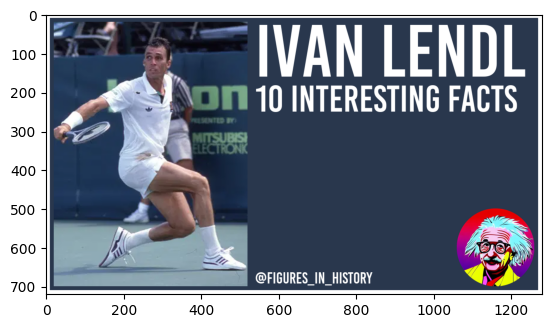

#-----------------THUMBNAIL 2-----------------#



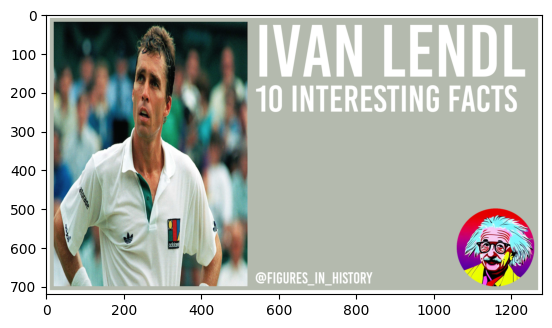

#-----------------THUMBNAIL 3-----------------#



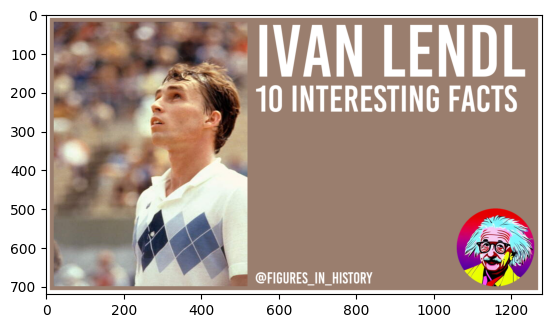

#-----------------THUMBNAIL 4-----------------#



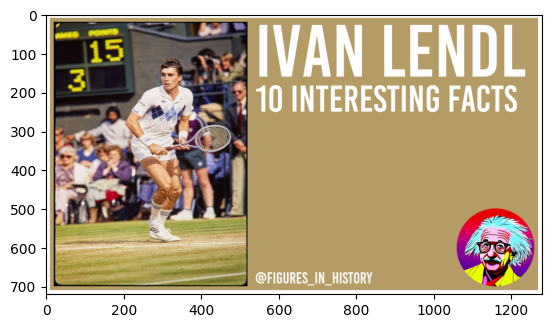

#-----------------THUMBNAIL 5-----------------#



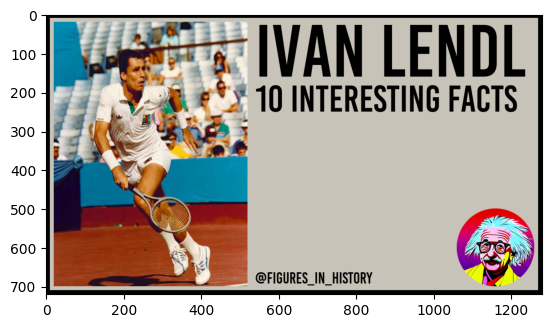

#-----------------THUMBNAIL 6-----------------#



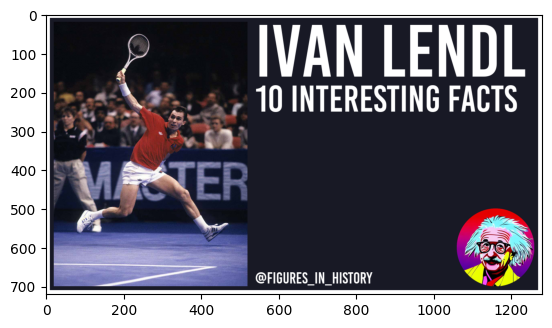

#-----------------THUMBNAIL 7-----------------#



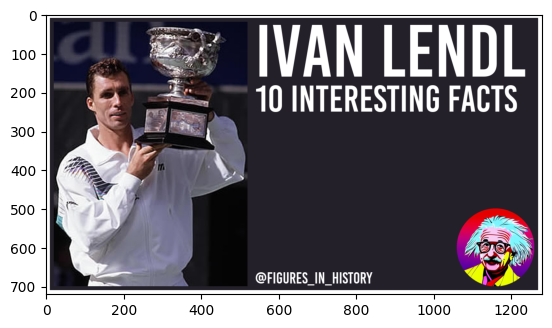

#-----------------THUMBNAIL 8-----------------#



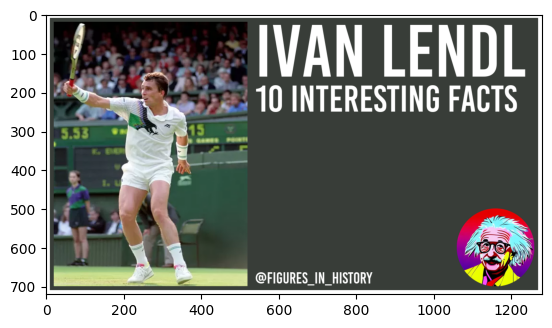

Choose which thumbnail you would like to use: 1 to 8 5


In [75]:
YouTube_preparation("Ivan Lendl")

## Upload to YouTube

The code below will take a sample of at most 5 videos which are already prepared and iteratively add them to YouTube while asking the user to select the thumbnail.

Here the code grabs the last date of the uploaded scheduled videos on the users channel and then creates a date table containing only Mon, Wed, Fri which are the upload days and iteratively uploads each video on the dates in the date table.

The user will need to accept authorisation from their account in order for the code to run.

In [76]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')
# We will grab any figures who have a script and audio complete but no video.
need_upload = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "Yes") &
                                     (historical_figures_list.Images_Obtained == "Yes") &
                                     (historical_figures_list.Youtube_Video_Created == "Yes") &
                                    (historical_figures_list.Youtube_Video_Posted == "No")]

# Allowed to upload 5 videos a day so this will pick a random sample of 5 which are ready to upload
def sample_rows(df, sample_size=5):
    
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input is not a valid DataFrame")
    
    row_count = len(df)
    
    # If the DataFrame has less than 10 rows or the sample_size is less than 10
    if row_count < 10 or (sample_size < 10 and sample_size > 0):
        sample_size = min(row_count, sample_size)
    
    return df.sample(n=sample_size)

need_upload = sample_rows(need_upload)

In [77]:
need_upload

,Figure_ID,Name,Description,Script_Created,AI_Voice_Generated,Images_Obtained,Youtube_Video_Created,Youtube_Video_Posted,Youtube_URL,Word_Count,Model_Used,Wikipedia
192,193,Ivan Lendl,Tennis player,Yes,Yes,Yes,Yes,No,NaN,1370.0,gpt-4o,https://en.wikipedia.org/wiki/Ivan_Lendl


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=837999920303-to0oms8geiv884s9hpt1qog77v1sivq1.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A61996%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.upload&state=4z2SZs42IwuRPe1ncsbcAY1zhS43LM&access_type=offline
                                          Title     Video ID  \
0             Carl Lewis - 10 Interesting Facts  2pQLiu5fdmQ   
1            Olga Korbut - 10 Interesting Facts  Z2CZSSs9_WM   
2    Sven-Göran Eriksson - 10 Interesting Facts  Xzh3hGw5Wag   
3     Napoleon Bonaparte - 10 Interesting Facts  9N-_aW6bWFU   
4             Henry VIII - 10 Interesting Facts  WExeJB9n2lw   
..                                          ...          ...   
186  William Shakespeare - 10 Interesting Facts  Mb64FlPHKTU   
187       Amelia Earhart - 10 Interesting Facts  w3lSCQYbIZA   
1

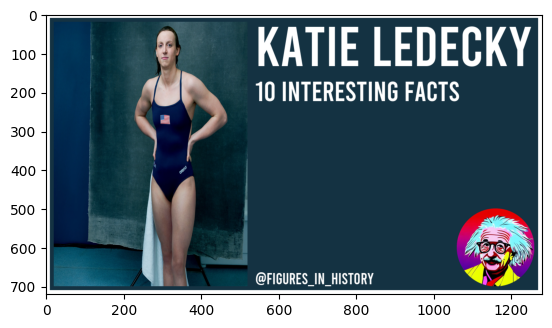

#-----------------THUMBNAIL 2-----------------#



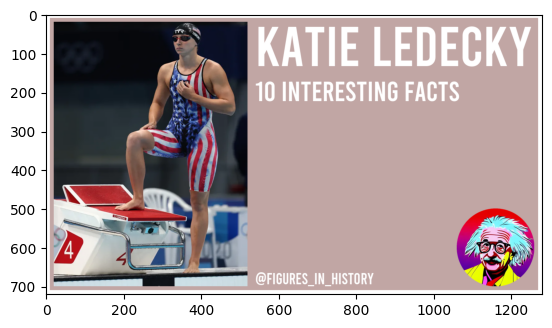

#-----------------THUMBNAIL 3-----------------#



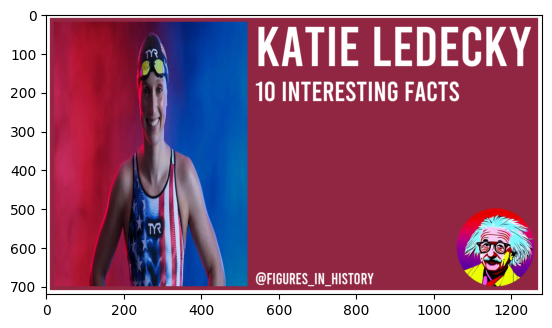

#-----------------THUMBNAIL 4-----------------#



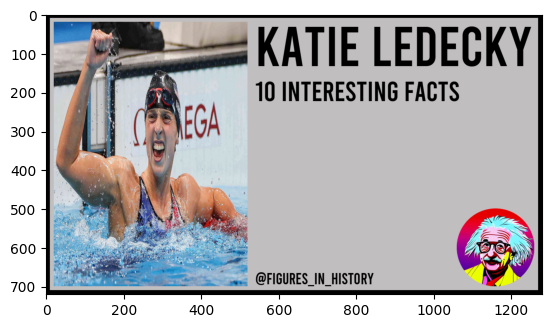

#-----------------THUMBNAIL 5-----------------#



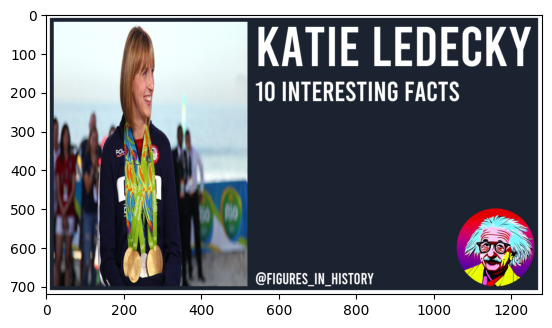

#-----------------THUMBNAIL 6-----------------#



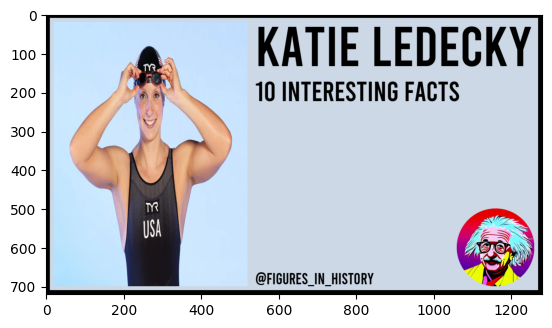

Choose which thumbnail you would like to use: 1 to 6 1


Katie Ledecky Video Uploaded
All Done Laa!


In [49]:
if need_upload.shape[0] > 0:
    
    # Load all the required packages
    import os
    import io
    import google_auth_oauthlib.flow
    import googleapiclient.discovery
    import googleapiclient.errors
    from googleapiclient.http import MediaFileUpload
    from google_auth_oauthlib.flow import InstalledAppFlow
    from pandas.tseries.offsets import Day
    from datetime import datetime, timedelta, timezone
    
    # Disable OAuthlib's HTTPS verification when running locally.
    # DO NOT leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    # Initiate the api calls, make sure the two scopes are included
    api_service_name = "youtube"
    api_version = "v3"
    client_secrets_file = "YouTube API Credentials.json"
    scopes = ["https://www.googleapis.com/auth/youtube.readonly",
              "https://www.googleapis.com/auth/youtube.upload"]

    # Get credentials and create an API client
    flow = InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
    credentials = flow.run_local_server(port=0)
    youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials=credentials)
    
    #----GET THE USER'S LAST SCHEDULED UPLOAD----#
    
    # Retrieve your channel's information to get the uploads playlist ID
    request = youtube.channels().list(part="contentDetails", mine=True)
    response = request.execute()

    # Get the uploads playlist ID
    uploads_playlist_id = response["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]

    # Fetch videos from the uploads playlist
    private_videos = []
    public_videos = []
    next_page_token = None

    while True:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=uploads_playlist_id,
            maxResults=50,  # Adjust as needed
            pageToken=next_page_token
        )

        response_playlist = request.execute()

        video_ids = [item['contentDetails']['videoId'] for item in response_playlist['items']]

        if video_ids:
            request_videos = youtube.videos().list(
                part="snippet,status",
                id=','.join(video_ids)
            )
            response_videos = request_videos.execute()
            for item in response_videos["items"]:
                if item["status"]["privacyStatus"] == "private":
                    video_data = {
                        "Title": item["snippet"]["title"],
                        "Video ID": item["id"],
                        "Publish Date": item["snippet"]["publishedAt"],
                        "Scheduled Date": item["status"].get("publishAt", "Not Scheduled")
                    }
                    private_videos.append(video_data)
                elif item["status"]["privacyStatus"] == "public":
                    video_data = {
                        "Title": item["snippet"]["title"],
                        "Video ID": item["id"],
                        "Publish Date": item["snippet"]["publishedAt"],
                        "Scheduled Date": item["status"].get("publishAt", "Not Scheduled")
                    }
                    public_videos.append(video_data)
        next_page_token = response_playlist.get("nextPageToken")
        if not next_page_token:
            break

    # Combine the lists of videos into a single dataframe
    df_private_videos = pd.DataFrame(private_videos)
    df_public_videos = pd.DataFrame(public_videos)

    combined_videos = pd.concat([df_private_videos, df_public_videos], ignore_index=True)
    
    # Define a default minimum date
    default_min_date = pd.Timestamp.min.replace(tzinfo=timezone.utc)

    # Convert 'Publish Date' and 'Scheduled Date' to datetime, replacing invalid or placeholder values
    combined_videos['Publish Date'] = pd.to_datetime(
        combined_videos['Publish Date'], errors='coerce'
    ).fillna(default_min_date)

    combined_videos['Scheduled Date'] = pd.to_datetime(
        combined_videos['Scheduled Date'].replace("Not Scheduled", None), errors='coerce'
    ).fillna(default_min_date)

    # Get the maximum values for each column
    max_publish_date = combined_videos['Publish Date'].max()
    max_scheduled_date = combined_videos['Scheduled Date'].max()

    # Find the overall maximum date
    overall_max_date = max(max_publish_date, max_scheduled_date)

    latest_scheduled_date = overall_max_date.date()
    
    #----CREATE A DATE TABLE BASED ON THE LAST UPLOAD DATE----#
    
    # Define your start and end dates
    start_date = latest_scheduled_date
    end_date = latest_scheduled_date + timedelta(days = 365)
    
    # Generate date range
    dates = pd.date_range(start=start_date, end=end_date, freq=Day())

    # Create DataFrame
    date_table = pd.DataFrame({'Date': dates})
    date_table['Weekday'] = date_table['Date'].dt.weekday
    # Add a fixed time (12:00:00) to each date and convert to UTC Timestamp
    date_table['Timestamp_UTC'] = pd.to_datetime(date_table['Date'].apply(lambda d: d.replace(hour=12, minute=0, second=0)))

    # Filter for Monday (0), Wednesday (2), and Friday (4)
    date_table = date_table[date_table['Weekday'].isin([0, 2, 4])]

    # Remove the top row as that video is already uploaded
    date_table = date_table.iloc[1:]
    
    #----NOW LOOP THROUGH FIGURES AND UPLOAD THE VIDEOS----#

    images_loc = "./Images/"
    
    # Get the figures who need a video making
    figure_upload = list(need_upload.iloc[:,1].values)
    
    for figure in figure_upload:
        move_video(figure)
        
        schedule_date = date_table.iloc[figure_upload.index(figure),2]
        # Convert to desired format
        schedule_date = schedule_date.strftime("%Y-%m-%dT%H:%M:%SZ")
        
        title = figure + " - 10 Interesting Facts"
        
        yt_desc = create_description(description, "[Historical Figure]", figure, "[model]")
 
        #----CREATE THE THUMBNAIL----#
    
        # Images for thumbnail function
        image_location = images_loc + figure + "/"
        all_images = os.listdir(image_location)
        thumbnails = [x for x in all_images if x.startswith('t')]
        thumbnails.sort()
    
        option = 1
        for thumbnail in thumbnails:
        
            print_option = "#-----------------THUMBNAIL " + str(option) + "-----------------#\n"
            print(print_option)
        
            save_location = "./Thumbnails/" + figure + "-" + thumbnail
            thumbnail_generator(image_location = image_location + thumbnail,
                                title_text = figure,
                                YT_logo_location = 'YT Profile.jpg',
                                YT_channel = "@Figures_In_History",
                                font_location = "./Fonts/Bebas-Regular.ttf",
                                save_location = save_location)
            option += 1
    
        i = 0
        while i == 0:
            string = "Choose which thumbnail you would like to use: 1 to " + str(len(thumbnails))
            thumbnail_choice = input(string)
          
            if int(thumbnail_choice) > len(thumbnails):
                i = 0
            else:
                file_loc = "./Thumbnails/" + figure + "-" + "thumbnail" + thumbnail_choice + ".png"
                shutil.copy(file_loc, "thumbnail.png")
                i = 1
        
        #----UPLOAD THE VIDEO----#
        
        # Specify the file path for your video and thumbnail
        video_file = "video.mp4"
        thumbnail_file = "thumbnail.png"

        # Create the request
        request_body = {
            "snippet": {
                "categoryId": "22",  # You can change this to the appropriate category
                "title": title,
                "description": yt_desc #,
                #"tags": ["tag1", "tag2"]  # Add relevant tags
            },
            "status": {
                "privacyStatus": "private",  # Must be private for scheduling
                "publishAt": schedule_date,  # Scheduled publishing time (UTC)
                "madeForKids": False  # Not made for kids
            }
        }

        # Call the API to upload the video
        media_file = MediaFileUpload(video_file, chunksize=-1, resumable=True)
        response_upload = youtube.videos().insert(
            part="snippet,status",
            body=request_body,
            media_body=media_file
        ).execute()

        # Call the API to upload the thumbnail
        youtube.thumbnails().set(
            videoId=response_upload.get("id"),
            media_body=MediaFileUpload(thumbnail_file)
        ).execute()

        # Get the video ID from the response
        video_id = response_upload.get("id")

        # Construct the video URL
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        
        #----SAVE INFORMATION----#
        
        # Change the image obtained to yes for the specified figure and save
        historical_figures_list.iloc[(historical_figures_list.Name == figure),7] = "Yes"
        historical_figures_list.iloc[(historical_figures_list.Name == figure),8] = video_url
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
        
        print(f"{figure} Video Uploaded")
    
    print("All Done Laa!")